<a href="https://colab.research.google.com/github/WenyuCho/Generative-AI/blob/main/Homework/GenAI_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **結果展示：**

針對我提供六篇與大型語言模型(LLM)相關的論文(pdf檔案)進行相關文提的回答，其中論文有 :

1.   HETFORMER (https://arxiv.org/abs/2110.06388)
2.   Longformer (https://arxiv.org/pdf/2004.05150)
3.   LongT5 (https://arxiv.org/pdf/2112.07916)
4.   SelfExtend (https://arxiv.org/pdf/2401.01325)
5.   Self-Route (https://arxiv.org/pdf/2407.16833)
6.   YaRN (https://arxiv.org/pdf/2309.00071)





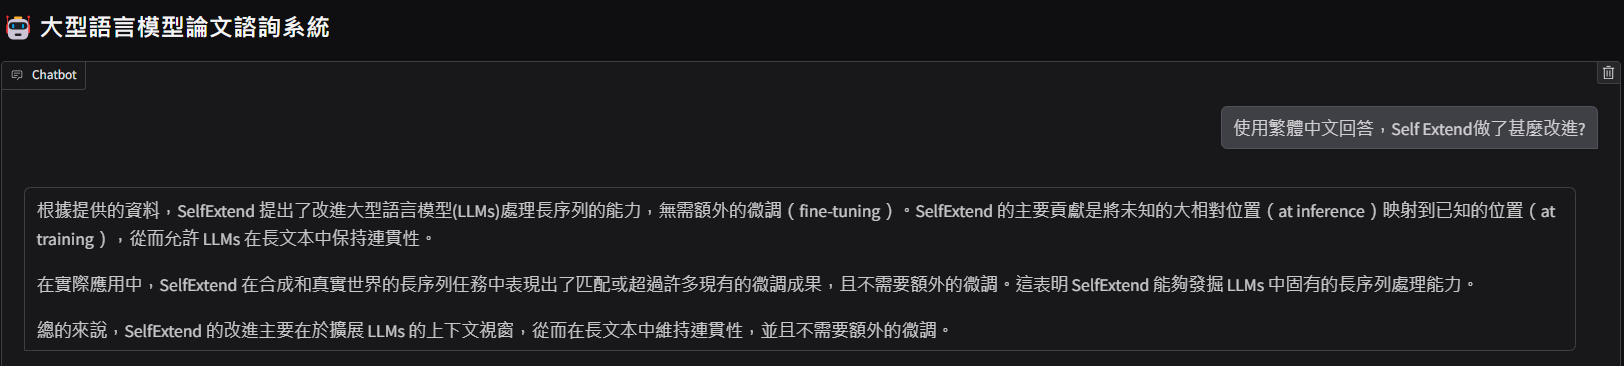

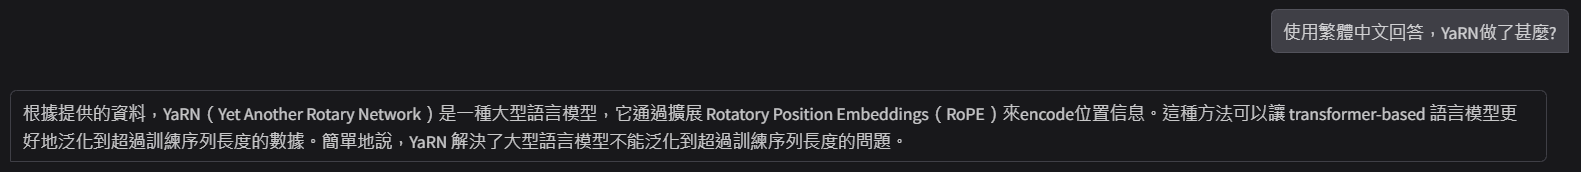

**以上兩個問題都是針對該論文的方法進行回答，回答十分正確。**

## **程式碼實作：**

### 1. 建立資料夾


In [ ]:
import os
upload_dir = "uploaded_docs"
os.makedirs(upload_dir, exist_ok=True)
print(f"請將你的 .txt, .pdf, .docx 檔案放到這個資料夾中： {upload_dir}")

# <font color="red">請手動上傳自己的檔案再繼續。</font>

### 2. 更新必要套件並引入

In [ ]:
!pip install -U langchain langchain-community pypdf python-docx sentence-transformers faiss-cpu

In [ ]:
from langchain_community.document_loaders import TextLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS #meta的向量資料庫套件

### 3. 依 e5 建議加入

自訂支援 E5 的 embedding 模型（加上 "passage:"(資料庫的) / "query:" 前綴）

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings

class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts] #文字轉向量
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")  #問題轉向量

### 4. 載入文件

In [ ]:
folder_path = upload_dir
documents = []
for file in os.listdir(folder_path):
    path = os.path.join(folder_path, file)
    if file.endswith(".txt"):
        loader = TextLoader(path)
    elif file.endswith(".pdf"):
        loader = PyPDFLoader(path)
    elif file.endswith(".docx"):
        loader = UnstructuredWordDocumentLoader(path)
    else:
        continue
    documents.extend(loader.load())

### 5. 建立向量資料庫

In [ ]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = splitter.split_documents(documents)

In [ ]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")#指定的embeddding model 處理成向量資料庫
vectorstore = FAISS.from_documents(split_docs, embedding_model)

### 6. 儲存向量資料庫

In [ ]:
vectorstore.save_local("faiss_db")

In [ ]:
!zip -r faiss_db.zip faiss_db

In [ ]:
print("✅ 壓縮好的向量資料庫已儲存為 'faiss_db.zip'，請下載此檔案備份。")

**直接下載連結**

https://drive.google.com/uc?export=download&id=1xTVs2V7C_mhAHvrlJdNFHOctHw9wNa79


# **開始生成大型語言模型論文諮詢系統**

In [38]:
#讀取下載連結檔案
URL = "https://drive.google.com/uc?export=download&id=1xTVs2V7C_mhAHvrlJdNFHOctHw9wNa79"
!wget -O faiss_db.zip "$URL"

--2025-04-21 12:53:58--  https://drive.google.com/uc?export=download&id=1xTVs2V7C_mhAHvrlJdNFHOctHw9wNa79
Resolving drive.google.com (drive.google.com)... 172.217.0.78, 2607:f8b0:4025:810::200e
Connecting to drive.google.com (drive.google.com)|172.217.0.78|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1xTVs2V7C_mhAHvrlJdNFHOctHw9wNa79&export=download [following]
--2025-04-21 12:53:58--  https://drive.usercontent.google.com/download?id=1xTVs2V7C_mhAHvrlJdNFHOctHw9wNa79&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1346359 (1.3M) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>]   1.28M  --.-KB/s    in 0.1s    

20

In [ ]:
#解壓縮導入的向量資料庫檔案
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


### 1. 安裝並引入必要套件

In [39]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

In [40]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [41]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [42]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    #這邊可以不用
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)
    #將輸入的問題轉為向量
    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db(meta開發套件)`

In [43]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定好我們要的 LLM

In [44]:
import os
from google.colab import userdata

如之前, 我們會用 OpenAI API。使用 Groq 服務

In [45]:
api_key = userdata.get('Groq')

In [46]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq

In [47]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [48]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [49]:
system_prompt = "不管使用者輸入的問題為何，請都用繁體中文回應，非常重要，繁體中文。你是一個關於大型語言模型論文分析的系統，用來回應有關論文內容相關問題，請以專業、盡量淺白易懂且詳細的方式回答。"

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

使用者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴使用者需要自行搜索相關資訊。
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [50]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ]
    )
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [52]:
with gr.Blocks() as demo:
    gr.Markdown("## 🤖 大型語言模型論文諮詢系統")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(placeholder="💬請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-52-37e4c227d73f>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ee520daadb88563c41.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3c4ff4c204800493f6.gradio.live
Killing tunnel 127.0.0.1:7860 <> https://ee520daadb88563c41.gradio.live
